## Test_Baseline_Code:  Scene Classification

### A. Problem Motivation: 

???

### B.  Dataset Description

Dataset: https://www.kaggle.com/datasets/nitishabharathi/scene-classification?resource=download&select=train-scene+classification

This dataset contains about ~25k images from a wide range of natural scenes from all around the world. The task is to identify which kind of scene can the image be categorized into.

It is a 6 class problem

 1. Buildings
 2. Forests
 3. Mountains
 4. Glacier
 5. Street
 6. Sea


### C. Solution/ Approach Description
#### C1.  Imports

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

#### C2. Configurations, Data Load, Global Variables

In [2]:
# added GPU configs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

In [3]:
# file read
img_path = "./train_scene_classification/train/"             # get image file path
df = pd.read_csv("./train_scene_classification/train.csv")   # read label csv

# label_id to name
# the labels have been rearranged from the order it is described in kaggle 
# to how labels correspond to images in train.csv
label_name = ['buildings','forests','glacier','mountains','sea','street']

# var counts
class_count = len(label_name)                                # class count: refer to Kaggle class descriptions
img_count = len(os.listdir(img_path))                        # number of images in img_path
lbl_count = len(df)                                          # number of labels in train.csv 

print("Check var_counts:")
print("class_count:", class_count)
print("img_count:", img_count)
print("lbl_count:", lbl_count)

Check var_counts:
class_count: 6
img_count: 24335
lbl_count: 17034


#### C3.  Exploratory Analysis

Not all images conform to shape (150,150,3).  There are two ways to remedy this-- we can omit from our final sampling the non-conforming images, or apply padding to make all images uniform in shape. This can be done by setting **"pad_img_var"** below to either **True** or **False**.  Since not all images have labels (see var_counts) and not all labels will be part of the final training/testing sets anyway, then setting **pad_img_arr** to **False** seems more practical.

In [4]:
# Sort by Label Classification
img_sorted = [0] * class_count
img_sorted = [[] for i in range(class_count)]

img_tmp = []
lbl_tmp = []

non_conform_count = 0

pad_img_arr = False

for i in range(lbl_count): 
    j = df.label[i]
    k = df.image_name[i]
    
    img = load_img(img_path+k)
    
    m = img_to_array(img)
    
    if m.shape != (150,150,3):
        non_conform_count += 1
        
        if pad_img_arr:
            m = np.pad(m,[(0,150 - m.shape[0]),(0,0),(0,0)])
        else:
            continue
    
    img_sorted[j].append(img)
    img_tmp.append(m)
    lbl_tmp.append(j)

print("No. of images not of shape (150,150,3):",non_conform_count)

No. of images not of shape (150,150,3): 55


Sample IDs per label: [1508, 1711, 2280, 761, 1461]
BUILDINGS:


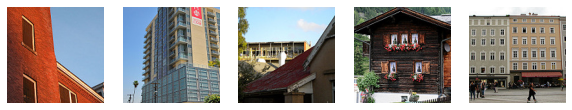

Sample IDs per label: [1260, 2333, 1887, 782, 153]
FORESTS:


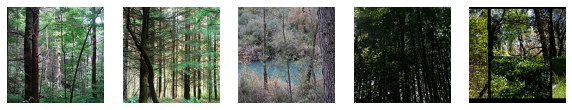

Sample IDs per label: [2718, 2225, 1897, 2435, 1498]
GLACIER:


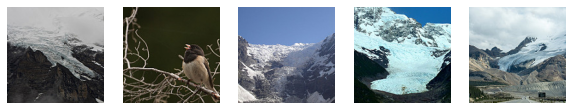

Sample IDs per label: [1241, 2960, 2582, 887, 2024]
MOUNTAINS:


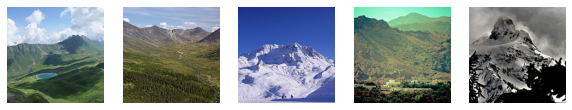

Sample IDs per label: [1133, 230, 1234, 2566, 1514]
SEA:


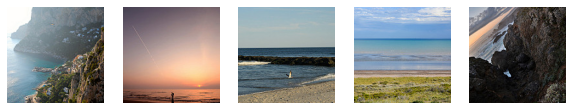

Sample IDs per label: [1036, 2278, 381, 977, 545]
STREET:


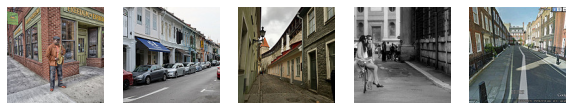

In [5]:
# number of images from each class to be included in the training, validation and testing sets
samp_count = 2000

# number of sample images to be previewed 
sub_samp = 5

samp = [0] * class_count
samp = [[] for i in range(class_count)]

gray = [0] * class_count
gray = [[] for i in range(class_count)]

img_arr = []
lbl_arr = []
gra_arr = []

def plot_sample_images(img):
    fig = plt.figure(figsize=(10,20))
    gs = fig.add_gridspec(1,sub_samp)

    ax = [fig.add_subplot(gs[0,i]) for i in range(sub_samp)]
    
    for j in range(sub_samp):
        ax[j].imshow(img[j])
        ax[j].axis('off')
    
    plt.show()
    
for i in range(class_count):
    r = random.sample(range(0, len(img_sorted[i])), samp_count)
    
    for j in range(samp_count):
        m = img_tmp[r[j]]
        
        img_arr.append(m)
        lbl_arr.append(lbl_tmp[r[j]])
        gra_arr.append(tf.image.rgb_to_grayscale(m))

    for j in range(sub_samp):
        m = img_sorted[i][r[j]]
        
        samp[i].append(m)
        gray[i].append(tf.image.rgb_to_grayscale(m))
        
    print(f'Sample IDs per label: {r[:sub_samp]}\n{label_name[i].upper()}:')
    plot_sample_images(samp[i])
    

#### C4. Approach

Before we apply any hyperparameter tuning, we want compare the accuracies between a *CNN/Conv2 on the full RGB* vs. a simple *Logistic approach on the grayscale converted images*.  We think that *scene classification* should be more about shapes than colors (in fact, colors might even convolute the model) and hence the need to experiment on a grayscale approach.

### D. Experiment: CNN/Conv2/RGB

In [6]:
# Convert image and label lists to numpy arrays 
img_arr = np.array(img_arr)
lbl_arr = np.array(lbl_arr)

# Validate: image and label shapes
print(f'original : ndim: {img_arr.ndim}, shape: {img_arr.shape}, type: {type(img_arr)}')
print(f'label    : ndim: {lbl_arr.ndim}, shape: {lbl_arr.shape}, type: {type(lbl_arr)}')

original : ndim: 4, shape: (12000, 150, 150, 3), type: <class 'numpy.ndarray'>
label    : ndim: 1, shape: (12000,), type: <class 'numpy.ndarray'>


#### D1. Preprocess the Data

In [7]:
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data(images, labels, split=(0.6,0.2,0.2),aug_img=False):    
    ## create train/validation/test sets 
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, labels = images[shuffle], labels[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(labels, [splits[0], splits[0]+splits[1]])
    
    ## image transformation on training, validation, and test data

    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    ## image augmentation on training data 
    
    if aug_img:
        # adjust brightness
        X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

        # adjust contrast
        X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

        # random flip
        # X_train_augm = tf.image.random_flip_left_right(X_train_augm)

        # concatenate original X_train and augmented X_train data
        X_train = tf.concat([X_train, X_train_augm],axis=0)

        # concatenate y_train (note the label is preserved)
        y_train_augm = y_train
        y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    ## shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(
    images=img_arr,
    labels=lbl_arr,
    split=(0.6,0.2,0.2),
    aug_img=False)

print("Validate shape")
print(f"   X_train shape {X_train.shape}")
print(f"   y_train shape {y_train.shape}")
print(f"   X_val shape {X_val.shape}")
print(f"   y_val shape {y_val.shape}")
print(f"   X_test shape {X_test.shape}")
print(f"   y_test shape {y_test.shape}")

print(f"\nTotal: {X_train.shape[0]+X_val.shape[0]+X_test.shape[0]} of {class_count*samp_count}")

Validate shape
   X_train shape (7200, 150, 150, 3)
   y_train shape (7200,)
   X_val shape (2400, 150, 150, 3)
   y_val shape (2400,)
   X_test shape (2400, 150, 150, 3)
   y_test shape (2400,)

Total: 12000 of 12000


#### D2. Build CNN Model

In [9]:
model = tf.keras.Sequential()

# first convolution layer
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))

# max pooling layer with pool size (2,2), strides of 2
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), 
    name='pool_1'))

# second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), 
    name='pool_2'))

# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(rate=0.5))

model.add(tf.keras.layers.Dense(
    units=class_count,
    name='fc_2',
    activation=None))

# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 150, 150, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 75, 75, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 37, 37, 64)        0         
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 fc_1 (Dense)                (None, 1024)              89719808  
                                                                 
 dropout (Dropout)           (None, 1024)              0

#### D3. Compile and Fit the Model

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #True, #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=2, 
                    validation_data=(X_val, y_val))


Epoch 1/2
225/225 [==============================] - 211s 931ms/step - loss: -24.4350 - accuracy: 0.1519 - val_loss: -25.5870 - val_accuracy: 0.1700
Epoch 2/2
225/225 [==============================] - 208s 926ms/step - loss: -24.6318 - accuracy: 0.1525 - val_loss: -25.5870 - val_accuracy: 0.1700


**We actually trained all the way up to epoch=10.  However, the accuracies don't seem to improve that much (in fact, is virtually flat).  So to save on processing time, we show here only up to epoch=2.**

#### D4. Plot History Summary

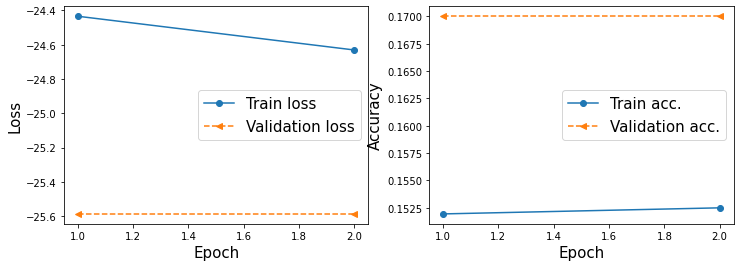

In [11]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

### E. Experiment: Logistic Regression/ Grayscale
#### E1. Explore Data

Grayscale images and arrays were preprocessed above

In [12]:
gra_arr = np.array(gra_arr)
lbl_arr = np.array(lbl_arr)

print(f'grayscale : ndim: {gra_arr.ndim}, shape: {gra_arr.shape}, type: {type(gra_arr)}')
print(f'label     : ndim: {lbl_arr.ndim}, shape: {lbl_arr.shape}, type: {type(lbl_arr)}')

grayscale : ndim: 4, shape: (12000, 150, 150, 1), type: <class 'numpy.ndarray'>
label     : ndim: 1, shape: (12000,), type: <class 'numpy.ndarray'>


IN GRAYSCALE:

Label: BUILDINGS:


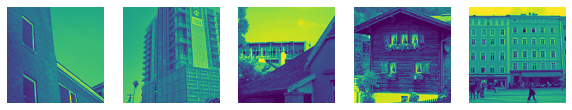

Label: FORESTS:


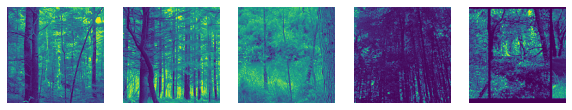

Label: GLACIER:


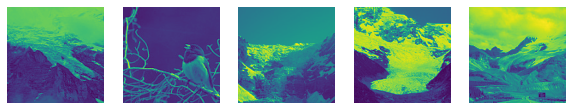

Label: MOUNTAINS:


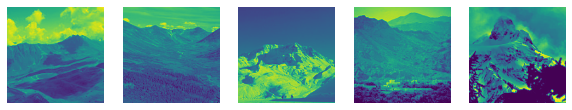

Label: SEA:


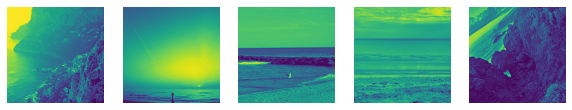

Label: STREET:


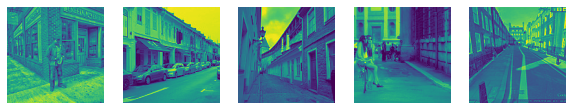

In [13]:
print("IN GRAYSCALE:\n")

for i in range(class_count):
    print(f'Label: {label_name[i].upper()}:')
    plot_sample_images(gray[i])

#### E2. Build Logistic Model

In [14]:
def build_model(n_classes, learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
        n_classes: Number of classes in the dataset
        learning_rate: The desired learning rate for SGD.

    Returns:
        model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax'
    ))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer, 
                metrics=['accuracy'])
    
    return model

#### E3. Fit Model and Display Results

In [15]:
model = build_model(class_count, 0.001)

history = model.fit(
  x = gra_arr,
  y = lbl_arr,
  epochs=100,
  batch_size=64,
  validation_split=0.2,
  verbose=0)

history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,val_loss,val_accuracy
0,78379.546875,0.234479,64373.187500,0.260000
1,66341.367188,0.269167,58586.660156,0.311667
2,63258.507812,0.274063,66800.664062,0.265000
3,56985.292969,0.296667,54640.828125,0.320000
4,59803.328125,0.296875,86661.023438,0.266667
...,...,...,...,...
95,2360.184082,0.918333,542.191956,0.940833
96,1171.377563,0.933333,289.735138,0.973333
97,1053.975830,0.946250,1413.200684,0.885000
98,622.997314,0.959063,234.273209,0.978333


### F. Conclusions Drawn as a Result of the Baseline Experiments

**Clearly, the baseline logistic approach shows a remarkably higher accracy vs. CNN's (0.9683 after 100 epochs vs 0.17.  As a note, Logistic's 100 epochs processed much faster than CNN's 2.  Again the accuracy of CNN at 2 epochs is the same as in 10.  So, we could imagine that the result wouldn't be that different at 100 epochs).**

**The next steps here are to experiment on CNN but using CNN/Conv1 using grayscale and to do more hyperparameter tuning.**